In [1]:
import pip

package_names = ['awswrangler'] 
pip.main(['install'] + package_names + ['--upgrade'])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


0

In [2]:
# Nativos
from dateutil.relativedelta import relativedelta
from time import gmtime, strftime
from datetime import datetime
import random as rn
import joblib
import json
import sys
import os
import gc

#nube
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker import get_execution_role
import awswrangler as wr
import sagemaker
import boto3

#calculo
import pandas as pd
import numpy as np
import scipy

#grafico
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")

#Interacciones con output
import warnings
warnings.filterwarnings("ignore")
# warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

gc.collect()
# MODELS
#from lightgbm import LGBMClassifier

BASE_DIR = os.path.dirname(os.getcwd())
if BASE_DIR not in sys.path: sys.path.append(BASE_DIR)
#import scorecardpy as sc
#from utils import *
#from graphs import *

SEED = 29082013
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
rn.seed(SEED)

#from utils import *
#from modeler import *
#subfolder = "data"
# os.listdir(subfolder)

from setup import *

////////////////////////////////////////////////// 

path_container_input:  /opt/ml/processing/input
path_container_output:  /opt/ml/processing/output
path_container_utils:  /opt/ml/processing/input/utils
path_container_universo:  /opt/ml/processing/input/HM_UNIVERSO_PROPENSION_DESEMBOLSO_BPE
target :::::::::  target_desembolso_f2m_mayor_30_menor_180


In [3]:
# imports
from UTILITARIO_CODE.utils import targets
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.amazon.amazon_estimator import get_image_uri
import awswrangler as wr
import pandas as pd
import sagemaker
import boto3

print("bucket: ", bucket)
print("region: ", region)
print("now: ", now)
print("sufijo: ", sufijo)

bucket:  sagemaker-us-east-1-058528764918
region:  us-east-1
now:  2021-09-28 04:07:04.953307
sufijo:  target_desembolso_f2m_mayor_30_menor_180_clasif_normal


In [4]:
print(len(seleccionadas))
print(seleccionadas)

19
['deuda_sf_prom_ult9m', 'saldo_coloc_direct_tc', 'prom_reprog_u12m', 'ult_var_saldo_ajustado_amt', 'nro_entid_financ_prom_ult9m_cnt', 'monto_adquirido_u6_amt', 'nro_var_10k_30k_negativa_u6', 'var_neta_saldo_ajustado_u3_amt', 'prom_gar_u12m', 'nroregs_reactiva_bcos', 'monto_pagado_u3_amt', 'saldo_coloc_direct_vig_bcos', 'saldo_coloc_direct_vig_cmpt', 'nro_entidades', 'monto_pagado_ult_rcc_amt', 'tendencia_nro_coloc_direct_bancos_v2', 'sow_cajas', 'prom_fae_u12m', 'nro_var_10k_30k_negativa_u3']


## >> LOAD DATA

In [5]:
from sklearn.metrics import roc_auc_score
grupos_score = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'][::-1]
cortes_deciles = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
cortes_deciles_fino = [0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99, 1]

In [6]:
grupos_score[-4:]

['D', 'C', 'B', 'A']

In [7]:
print("uri_output: ", uri_output)
print("uri_contraste: ", uri_contraste)
print("uri_predict: ", uri_predict)

uri_output:  s3://sagemaker-us-east-1-058528764918/vpc/propension/output3
uri_contraste:  s3://sagemaker-us-east-1-058528764918/vpc/propension/contraste
uri_predict:  s3://sagemaker-us-east-1-058528764918/vpc/propension/prediccion


** OJO: modificar esta parte en caso de cambios de periodos**

In [8]:
#uri_validation_202102 = uri_contraste + '/202102_{}.csv'.format(sufijo)
uri_validation_202103 = uri_contraste + '/202103_{}.csv'.format(sufijo)
uri_validation_202104 = uri_contraste + '/202104_{}.csv'.format(sufijo)
uri_validation_202105 = uri_contraste + '/202105_{}.csv'.format(sufijo)
uri_validation_202106 = uri_contraste + '/202106_{}.csv'.format(sufijo)
uri_validation_202107 = uri_contraste + '/202107_{}.csv'.format(sufijo)
uri_validation_202108 = uri_contraste + '/202108_{}.csv'.format(sufijo)

#print(uri_validation_202102)
print(uri_validation_202103)
print(uri_validation_202104)
print(uri_validation_202105)
print(uri_validation_202106)
print(uri_validation_202107)
print(uri_validation_202108)

s3://sagemaker-us-east-1-058528764918/vpc/propension/contraste/202103_target_desembolso_f2m_mayor_30_menor_180_clasif_normal.csv
s3://sagemaker-us-east-1-058528764918/vpc/propension/contraste/202104_target_desembolso_f2m_mayor_30_menor_180_clasif_normal.csv
s3://sagemaker-us-east-1-058528764918/vpc/propension/contraste/202105_target_desembolso_f2m_mayor_30_menor_180_clasif_normal.csv
s3://sagemaker-us-east-1-058528764918/vpc/propension/contraste/202106_target_desembolso_f2m_mayor_30_menor_180_clasif_normal.csv
s3://sagemaker-us-east-1-058528764918/vpc/propension/contraste/202107_target_desembolso_f2m_mayor_30_menor_180_clasif_normal.csv
s3://sagemaker-us-east-1-058528764918/vpc/propension/contraste/202108_target_desembolso_f2m_mayor_30_menor_180_clasif_normal.csv


In [9]:
#_2002 = wr.s3.read_csv(
#    uri_validation_202102, 
#    sep=',',
#)
#_2002.head(3)

In [10]:
_2003 = wr.s3.read_csv(
    uri_validation_202103, 
    sep=',',
)
_2003.head(3)

,prom_fae_u12m,nro_var_10k_30k_negativa_u3,saldo_coloc_direct_tc,saldo_coloc_indirectas,nro_var_10k_30k_negativa_u6,monto_pagado_u3_amt,nro_entid_financ_prom_ult9m_cnt,monto_adquirido_u6_amt,saldo_coloc_direct_vig_cmpt,porc_coloc_direct_vig_cmpt,monto_pagado_ult_rcc_amt,sow_ibk,saldo_coloc_directas,saldo_coloc_direct_vig_no_ibk,prom_gar_u12m,nroregs_reactiva_bcos,cod_sbs_val,saldo_coloc_direct_vig_ibk,nro_entidades,target_desembolso_f2m_mayor_30_menor_180,saldo_coloc_direct_vig_bcos,prom_reprog_u12m,porc_coloc_direct_vig_ibk,porc_coloc_direct_vig_cajas,sow_otros_bancos,saldo_coloc_direct_vig_cajas,ult_var_saldo_ajustado_amt,porc_coloc_direct_vig_no_ibk,sow_cajas,deuda_sf_prom_ult9m,var_neta_saldo_ajustado_u3_amt,porc_coloc_direct_vig_bcos,saldo_fae,saldo_reactiva,nroregs_fae_bcos,tendencia_nro_coloc_direct_bancos_v2,_cuartil_saldo_coloc_directas,_categoryc_porc_coloc_direct_vig_bcos,_categoryc_porc_coloc_direct_vig_cmpt,_categoryc_porc_coloc_direct_vig_no_ibk,_categoryc_porc_coloc_direct_vig_ibk,_categoryc_porc_coloc_direct_vig_cajas,_categoryc_sow_ibk,_categoryc_sow_otros_bancos,_categoryc_sow_cajas,score_desembolso,GRUPO_PROPENSION,GRUPO_PROPENSION_FINO,_range_coloc_directas,_range_coloc_indirectas,_range_coloc_direct_vig_bcos,_range_coloc_direct_vig_cmpt,_range_coloc_direct_vig_no_ibk,_range_coloc_direct_vig_ibk,_range_coloc_direct_vig_cajas,_range_reactiva,_range_fae,_categoryc_coloc_direct_vig_bcos,_categoryc_coloc_direct_vig_competencia,_categoryc_coloc_direct_vig_no_ibk,_categoryc_coloc_direct_vig_ibk,_categoryc_coloc_direct_vig_cajas
0,0.000,0,0.0,0.0,0,1794.37,1,0.0,0.0,0.0,616.17,0.0,3918.83,0.0,0.00,0,48759904,0.0,1,0.0,0.0,4558.153333,0.0,1.0,0.0,3918.83,-616.17,0.0,1.0,6077.54,-1794.37,0.0,0.00,0.0,0,0.000000,D,0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],4. <0.75:0.9],0. <:0.0],0. <:0.0],4. <0.75:0.9],0.007450,I,I,1. <0-10k],0. <:0],0. <:0],0. <:0],0. <:0],0. <:0],1. <0-10k],0. <:0],0. <:0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],4. <0.75:0.9]
1,0.000,1,0.0,0.0,1,24166.88,1,900.0,0.0,0.0,0.00,0.0,4000.00,0.0,2.25,0,149898271,0.0,1,0.0,0.0,17737.965000,0.0,1.0,0.0,4000.00,900.00,0.0,1.0,24525.75,-23266.88,0.0,0.00,0.0,0,0.333333,D,0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],4. <0.75:0.9],0. <:0.0],0. <:0.0],4. <0.75:0.9],0.030875,C,E,1. <0-10k],0. <:0],0. <:0],0. <:0],0. <:0],0. <:0],1. <0-10k],0. <:0],0. <:0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],4. <0.75:0.9]
2,5833.625,0,0.0,0.0,0,0.00,1,0.0,0.0,0.0,0.00,0.0,0.00,0.0,1.00,0,126112726,0.0,1,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.00,0.0,0.0,7000.35,0.00,0.0,7000.35,0.0,1,1.000000,D,0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],0.007600,I,I,0. <:0],0. <:0],0. <:0],0. <:0],0. <:0],0. <:0],0. <:0],0. <:0],1. <0-10k],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0]


In [11]:
_2004 = wr.s3.read_csv(
    uri_validation_202104, 
    sep=',',
)

_2004.head(3)

,prom_fae_u12m,nro_var_10k_30k_negativa_u3,saldo_coloc_direct_tc,saldo_coloc_indirectas,nro_var_10k_30k_negativa_u6,monto_pagado_u3_amt,nro_entid_financ_prom_ult9m_cnt,monto_adquirido_u6_amt,saldo_coloc_direct_vig_cmpt,porc_coloc_direct_vig_cmpt,monto_pagado_ult_rcc_amt,sow_ibk,saldo_coloc_directas,saldo_coloc_direct_vig_no_ibk,prom_gar_u12m,nroregs_reactiva_bcos,cod_sbs_val,saldo_coloc_direct_vig_ibk,nro_entidades,target_desembolso_f2m_mayor_30_menor_180,saldo_coloc_direct_vig_bcos,prom_reprog_u12m,porc_coloc_direct_vig_ibk,porc_coloc_direct_vig_cajas,sow_otros_bancos,saldo_coloc_direct_vig_cajas,ult_var_saldo_ajustado_amt,porc_coloc_direct_vig_no_ibk,sow_cajas,deuda_sf_prom_ult9m,var_neta_saldo_ajustado_u3_amt,porc_coloc_direct_vig_bcos,saldo_fae,saldo_reactiva,nroregs_fae_bcos,tendencia_nro_coloc_direct_bancos_v2,_cuartil_saldo_coloc_directas,_categoryc_porc_coloc_direct_vig_bcos,_categoryc_porc_coloc_direct_vig_cmpt,_categoryc_porc_coloc_direct_vig_no_ibk,_categoryc_porc_coloc_direct_vig_ibk,_categoryc_porc_coloc_direct_vig_cajas,_categoryc_sow_ibk,_categoryc_sow_otros_bancos,_categoryc_sow_cajas,score_desembolso,GRUPO_PROPENSION,GRUPO_PROPENSION_FINO,_range_coloc_directas,_range_coloc_indirectas,_range_coloc_direct_vig_bcos,_range_coloc_direct_vig_cmpt,_range_coloc_direct_vig_no_ibk,_range_coloc_direct_vig_ibk,_range_coloc_direct_vig_cajas,_range_reactiva,_range_fae,_categoryc_coloc_direct_vig_bcos,_categoryc_coloc_direct_vig_competencia,_categoryc_coloc_direct_vig_no_ibk,_categoryc_coloc_direct_vig_ibk,_categoryc_coloc_direct_vig_cajas
0,0.000000,0,0.0,0.0,0,18275.16,0,250000.00,231724.84,1.0,9379.89,0.0,231724.84,231724.84,0.000000,0,203570678,0.0,1,0.0,231724.84,0.0000,0.0,0.000,1.000,0.00,-9379.89,1.000,0.000,80314.40,231724.84,1.000,0.00,0.0,0,0.0,A,4. <0.75:0.9],4. <0.75:0.9],4. <0.75:0.9],0. <:0.0],0. <:0.0],0. <:0.0],4. <0.75:0.9],0. <:0.0],0.031269,C,E,5. <180K:>,0. <:0],5. <180K:>,5. <180K:>,5. <180K:>,0. <:0],0. <:0],0. <:0],0. <:0],4. <0.75:0.9],4. <0.75:0.9],4. <0.75:0.9],0. <:0.0],0. <:0.0]
1,0.000000,0,0.0,0.0,0,0.00,0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.000000,1,183894013,0.0,1,0.0,0.00,0.0000,0.0,0.000,0.000,0.00,0.00,0.000,0.000,25441.24,0.00,0.000,0.00,28621.4,0,1.0,D,0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],0.006905,I,I,0. <:0],0. <:0],0. <:0],0. <:0],0. <:0],0. <:0],0. <:0],2. <10k:30k],0. <:0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0]
2,18727.464167,0,0.0,0.0,0,4265.70,1,10225.52,0.00,0.0,1384.21,0.0,73448.40,8600.59,0.833333,0,74279325,0.0,2,0.0,8600.59,81768.9575,0.0,0.883,0.117,64847.81,-1384.21,0.117,0.883,99463.00,-4265.70,0.117,17866.15,0.0,0,1.0,A,1. <0.0:0.25],0. <:0.0],1. <0.0:0.25],0. <:0.0],4. <0.75:0.9],0. <:0.0],1. <0.0:0.25],4. <0.75:0.9],0.033284,C,E,<3. 30k:120k],0. <:0],1. <0-10k],0. <:0],1. <0-10k],0. <:0],<3. 30k:120k],0. <:0],2. <10k:30k],1. <0.0:0.25],0. <:0.0],1. <0.0:0.25],0. <:0.0],4. <0.75:0.9]


In [12]:
_2005 = wr.s3.read_csv(
    uri_validation_202105, 
    sep=',',
)

_2005.head(3)

,prom_fae_u12m,nro_var_10k_30k_negativa_u3,saldo_coloc_direct_tc,saldo_coloc_indirectas,nro_var_10k_30k_negativa_u6,monto_pagado_u3_amt,nro_entid_financ_prom_ult9m_cnt,monto_adquirido_u6_amt,saldo_coloc_direct_vig_cmpt,porc_coloc_direct_vig_cmpt,monto_pagado_ult_rcc_amt,sow_ibk,saldo_coloc_directas,saldo_coloc_direct_vig_no_ibk,prom_gar_u12m,nroregs_reactiva_bcos,cod_sbs_val,saldo_coloc_direct_vig_ibk,nro_entidades,target_desembolso_f2m_mayor_30_menor_180,saldo_coloc_direct_vig_bcos,prom_reprog_u12m,porc_coloc_direct_vig_ibk,porc_coloc_direct_vig_cajas,sow_otros_bancos,saldo_coloc_direct_vig_cajas,ult_var_saldo_ajustado_amt,porc_coloc_direct_vig_no_ibk,sow_cajas,deuda_sf_prom_ult9m,var_neta_saldo_ajustado_u3_amt,porc_coloc_direct_vig_bcos,saldo_fae,saldo_reactiva,nroregs_fae_bcos,tendencia_nro_coloc_direct_bancos_v2,_cuartil_saldo_coloc_directas,_categoryc_porc_coloc_direct_vig_bcos,_categoryc_porc_coloc_direct_vig_cmpt,_categoryc_porc_coloc_direct_vig_no_ibk,_categoryc_porc_coloc_direct_vig_ibk,_categoryc_porc_coloc_direct_vig_cajas,_categoryc_sow_ibk,_categoryc_sow_otros_bancos,_categoryc_sow_cajas,score_desembolso,GRUPO_PROPENSION,GRUPO_PROPENSION_FINO,_range_coloc_directas,_range_coloc_indirectas,_range_coloc_direct_vig_bcos,_range_coloc_direct_vig_cmpt,_range_coloc_direct_vig_no_ibk,_range_coloc_direct_vig_ibk,_range_coloc_direct_vig_cajas,_range_reactiva,_range_fae,_categoryc_coloc_direct_vig_bcos,_categoryc_coloc_direct_vig_competencia,_categoryc_coloc_direct_vig_no_ibk,_categoryc_coloc_direct_vig_ibk,_categoryc_coloc_direct_vig_cajas
0,0.0,0,0.0,0.0,0,3927.10,1,11789.22,0.00,0.0,2558.09,0.0,43772.33,43772.33,2.155599e+04,1,30419162,0.0,1,0.0,43772.33,0.000000,0.0,0.000,1.000,0.00,-2558.09,1.000,0.000,59487.23,7862.12,1.000,0.0,24384.2,0,1.000,B,4. <0.75:0.9],0. <:0.0],4. <0.75:0.9],0. <:0.0],0. <:0.0],0. <:0.0],4. <0.75:0.9],0. <:0.0],0.033920,C,E,<3. 30k:120k],0. <:0],<3. 30k:120k],0. <:0],<3. 30k:120k],0. <:0],0. <:0],2. <10k:30k],0. <:0],4. <0.75:0.9],0. <:0.0],4. <0.75:0.9],0. <:0.0],0. <:0.0]
1,0.0,1,0.0,0.0,1,510933.58,2,633912.87,629297.28,1.0,22543.07,0.0,629297.28,629297.28,1.162966e+06,0,75300956,0.0,3,0.0,629297.28,328314.754167,0.0,0.000,1.000,0.00,-22543.07,1.000,0.000,589446.28,122979.29,1.000,0.0,0.0,0,0.875,A,4. <0.75:0.9],4. <0.75:0.9],4. <0.75:0.9],0. <:0.0],0. <:0.0],0. <:0.0],4. <0.75:0.9],0. <:0.0],0.077572,A,C,5. <180K:>,0. <:0],5. <180K:>,5. <180K:>,5. <180K:>,0. <:0],0. <:0],0. <:0],0. <:0],4. <0.75:0.9],4. <0.75:0.9],4. <0.75:0.9],0. <:0.0],0. <:0.0]
2,0.0,0,0.0,0.0,0,3224.89,2,0.00,0.00,0.0,958.23,0.0,28825.03,28798.82,2.000000e+00,0,69166024,0.0,2,0.0,28798.82,15639.696667,0.0,0.001,0.999,26.21,-958.23,0.999,0.001,33044.68,-3224.89,0.999,0.0,0.0,0,1.000,B,4. <0.75:0.9],0. <:0.0],4. <0.75:0.9],0. <:0.0],1. <0.0:0.25],0. <:0.0],4. <0.75:0.9],1. <0.0:0.25],0.008842,I,I,2. <10k:30k],0. <:0],2. <10k:30k],0. <:0],2. <10k:30k],0. <:0],1. <0-10k],0. <:0],0. <:0],4. <0.75:0.9],0. <:0.0],4. <0.75:0.9],0. <:0.0],1. <0.0:0.25]


In [13]:
_2005['target_desembolso_f2m_mayor_30_menor_180'].value_counts()

0.0    696307
1.0     19356
Name: target_desembolso_f2m_mayor_30_menor_180, dtype: int64

In [14]:
_2006 = wr.s3.read_csv(
    uri_validation_202106, 
    sep=',',
)

_2006.head(3)

,prom_fae_u12m,nro_var_10k_30k_negativa_u3,saldo_coloc_direct_tc,saldo_coloc_indirectas,nro_var_10k_30k_negativa_u6,monto_pagado_u3_amt,nro_entid_financ_prom_ult9m_cnt,monto_adquirido_u6_amt,saldo_coloc_direct_vig_cmpt,porc_coloc_direct_vig_cmpt,monto_pagado_ult_rcc_amt,sow_ibk,saldo_coloc_directas,saldo_coloc_direct_vig_no_ibk,prom_gar_u12m,nroregs_reactiva_bcos,cod_sbs_val,saldo_coloc_direct_vig_ibk,nro_entidades,target_desembolso_f2m_mayor_30_menor_180,saldo_coloc_direct_vig_bcos,prom_reprog_u12m,porc_coloc_direct_vig_ibk,porc_coloc_direct_vig_cajas,sow_otros_bancos,saldo_coloc_direct_vig_cajas,ult_var_saldo_ajustado_amt,porc_coloc_direct_vig_no_ibk,sow_cajas,deuda_sf_prom_ult9m,var_neta_saldo_ajustado_u3_amt,porc_coloc_direct_vig_bcos,saldo_fae,saldo_reactiva,nroregs_fae_bcos,tendencia_nro_coloc_direct_bancos_v2,_cuartil_saldo_coloc_directas,_categoryc_porc_coloc_direct_vig_bcos,_categoryc_porc_coloc_direct_vig_cmpt,_categoryc_porc_coloc_direct_vig_no_ibk,_categoryc_porc_coloc_direct_vig_ibk,_categoryc_porc_coloc_direct_vig_cajas,_categoryc_sow_ibk,_categoryc_sow_otros_bancos,_categoryc_sow_cajas,score_desembolso,GRUPO_PROPENSION,GRUPO_PROPENSION_FINO,_range_coloc_directas,_range_coloc_indirectas,_range_coloc_direct_vig_bcos,_range_coloc_direct_vig_cmpt,_range_coloc_direct_vig_no_ibk,_range_coloc_direct_vig_ibk,_range_coloc_direct_vig_cajas,_range_reactiva,_range_fae,_categoryc_coloc_direct_vig_bcos,_categoryc_coloc_direct_vig_competencia,_categoryc_coloc_direct_vig_no_ibk,_categoryc_coloc_direct_vig_ibk,_categoryc_coloc_direct_vig_cajas
0,0.0,0,0.00,0.0,0,1853.73,1,0.00,0.00,0.0,642.76,0.0,8950.36,8950.36,3.250,1,154769137,0.0,1,0.0,8950.36,1008.690000,0.0,0.000,1.000,0.00,-642.76,1.000,0.000,21749.62,-1853.73,1.000,0.0,10221.50,0,1.000000,C,4. <0.75:0.9],0. <:0.0],4. <0.75:0.9],0. <:0.0],0. <:0.0],0. <:0.0],4. <0.75:0.9],0. <:0.0],0.005127,J,J,1. <0-10k],0. <:0],1. <0-10k],0. <:0],1. <0-10k],0. <:0],0. <:0],2. <10k:30k],0. <:0],4. <0.75:0.9],0. <:0.0],4. <0.75:0.9],0. <:0.0],0. <:0.0]
1,0.0,0,85641.88,0.0,0,4374.28,1,21148.22,91387.35,1.0,2413.69,0.0,91387.35,91387.35,0.000,1,157683209,0.0,1,0.0,91387.35,88991.732500,0.0,0.000,1.000,0.00,-2413.69,1.000,0.000,113613.00,7293.25,1.000,0.0,26258.83,0,1.166667,A,4. <0.75:0.9],4. <0.75:0.9],4. <0.75:0.9],0. <:0.0],0. <:0.0],0. <:0.0],4. <0.75:0.9],0. <:0.0],0.016001,F,F,<3. 30k:120k],0. <:0],<3. 30k:120k],<3. 30k:120k],<3. 30k:120k],0. <:0],0. <:0],2. <10k:30k],0. <:0],4. <0.75:0.9],4. <0.75:0.9],4. <0.75:0.9],0. <:0.0],0. <:0.0]
2,0.0,0,0.00,0.0,0,4104.60,2,15233.98,0.00,0.0,854.97,0.0,25225.54,9445.35,5448.325,1,136905961,0.0,2,0.0,9445.35,6327.621667,0.0,0.626,0.374,15780.19,11925.22,0.374,0.626,30885.53,11129.38,0.374,0.0,15606.75,0,1.000000,C,2. <0.25:0.5],0. <:0.0],2. <0.25:0.5],0. <:0.0],3. <0.5:0.75],0. <:0.0],2. <0.25:0.5],3. <0.5:0.75],0.005851,J,J,2. <10k:30k],0. <:0],1. <0-10k],0. <:0],1. <0-10k],0. <:0],2. <10k:30k],2. <10k:30k],0. <:0],2. <0.25:0.5],0. <:0.0],2. <0.25:0.5],0. <:0.0],3. <0.5:0.75]


In [15]:
_2006['target_desembolso_f2m_mayor_30_menor_180'].value_counts()

0.0    718033
Name: target_desembolso_f2m_mayor_30_menor_180, dtype: int64

In [16]:
_2007 = wr.s3.read_csv(
    uri_validation_202107, 
    sep=',',
)

_2007.head(3)

,prom_fae_u12m,nro_var_10k_30k_negativa_u3,saldo_coloc_direct_tc,saldo_coloc_indirectas,nro_var_10k_30k_negativa_u6,monto_pagado_u3_amt,nro_entid_financ_prom_ult9m_cnt,monto_adquirido_u6_amt,saldo_coloc_direct_vig_cmpt,porc_coloc_direct_vig_cmpt,monto_pagado_ult_rcc_amt,sow_ibk,saldo_coloc_directas,saldo_coloc_direct_vig_no_ibk,prom_gar_u12m,nroregs_reactiva_bcos,cod_sbs_val,saldo_coloc_direct_vig_ibk,nro_entidades,target_desembolso_f2m_mayor_30_menor_180,saldo_coloc_direct_vig_bcos,prom_reprog_u12m,porc_coloc_direct_vig_ibk,porc_coloc_direct_vig_cajas,sow_otros_bancos,saldo_coloc_direct_vig_cajas,ult_var_saldo_ajustado_amt,porc_coloc_direct_vig_no_ibk,sow_cajas,deuda_sf_prom_ult9m,var_neta_saldo_ajustado_u3_amt,porc_coloc_direct_vig_bcos,saldo_fae,saldo_reactiva,nroregs_fae_bcos,tendencia_nro_coloc_direct_bancos_v2,_cuartil_saldo_coloc_directas,_categoryc_porc_coloc_direct_vig_bcos,_categoryc_porc_coloc_direct_vig_cmpt,_categoryc_porc_coloc_direct_vig_no_ibk,_categoryc_porc_coloc_direct_vig_ibk,_categoryc_porc_coloc_direct_vig_cajas,_categoryc_sow_ibk,_categoryc_sow_otros_bancos,_categoryc_sow_cajas,score_desembolso,GRUPO_PROPENSION,GRUPO_PROPENSION_FINO,_range_coloc_directas,_range_coloc_indirectas,_range_coloc_direct_vig_bcos,_range_coloc_direct_vig_cmpt,_range_coloc_direct_vig_no_ibk,_range_coloc_direct_vig_ibk,_range_coloc_direct_vig_cajas,_range_reactiva,_range_fae,_categoryc_coloc_direct_vig_bcos,_categoryc_coloc_direct_vig_competencia,_categoryc_coloc_direct_vig_no_ibk,_categoryc_coloc_direct_vig_ibk,_categoryc_coloc_direct_vig_cajas
0,0.0,0,0.00,0.0,0,0.00,1,0.00,0.01,1.0,0.00,0.0,0.01,0.01,0.0,1,67313267,0.0,1,0.0,0.01,0.000000,0.0,0.000,1.0,0.0,0.00,1.000,0.000,182353.38,0.00,1.000,0.0,175351.82,0,1.0,D,4. <0.75:0.9],4. <0.75:0.9],4. <0.75:0.9],0. <:0.0],0. <:0.0],0. <:0.0],4. <0.75:0.9],0. <:0.0],0.015278,F,F,1. <0-10k],0. <:0],1. <0-10k],1. <0-10k],1. <0-10k],0. <:0],0. <:0],4. <120k:180k],0. <:0],4. <0.75:0.9],4. <0.75:0.9],4. <0.75:0.9],0. <:0.0],0. <:0.0]
1,0.0,0,0.00,0.0,0,4031.59,1,21000.00,0.00,0.0,1701.57,0.0,58174.67,38195.57,0.0,0,28947739,0.0,2,0.0,38195.57,7515.042500,0.0,0.343,0.0,19979.1,-1701.57,0.657,0.343,45091.08,16968.41,0.657,0.0,0.00,0,1.0,B,3. <0.5:0.75],0. <:0.0],3. <0.5:0.75],0. <:0.0],2. <0.25:0.5],0. <:0.0],0. <:0.0],2. <0.25:0.5],0.029214,D,E,<3. 30k:120k],0. <:0],<3. 30k:120k],0. <:0],<3. 30k:120k],0. <:0],2. <10k:30k],0. <:0],0. <:0],3. <0.5:0.75],0. <:0.0],3. <0.5:0.75],0. <:0.0],2. <0.25:0.5]
2,0.0,0,16.99,0.0,0,3020.67,0,3501.56,16.99,1.0,2865.61,0.0,16.99,16.99,0.0,0,53816525,0.0,1,0.0,16.99,723.640833,0.0,0.000,1.0,0.0,-2865.61,1.000,0.000,842.23,-183.01,1.000,0.0,0.00,0,1.5,D,4. <0.75:0.9],4. <0.75:0.9],4. <0.75:0.9],0. <:0.0],0. <:0.0],0. <:0.0],4. <0.75:0.9],0. <:0.0],0.011504,H,H,1. <0-10k],0. <:0],1. <0-10k],1. <0-10k],1. <0-10k],0. <:0],0. <:0],0. <:0],0. <:0],4. <0.75:0.9],4. <0.75:0.9],4. <0.75:0.9],0. <:0.0],0. <:0.0]


In [17]:
_2008 = wr.s3.read_csv(
    uri_validation_202107, 
    sep=',',
)

_2008.head(3)

,prom_fae_u12m,nro_var_10k_30k_negativa_u3,saldo_coloc_direct_tc,saldo_coloc_indirectas,nro_var_10k_30k_negativa_u6,monto_pagado_u3_amt,nro_entid_financ_prom_ult9m_cnt,monto_adquirido_u6_amt,saldo_coloc_direct_vig_cmpt,porc_coloc_direct_vig_cmpt,monto_pagado_ult_rcc_amt,sow_ibk,saldo_coloc_directas,saldo_coloc_direct_vig_no_ibk,prom_gar_u12m,nroregs_reactiva_bcos,cod_sbs_val,saldo_coloc_direct_vig_ibk,nro_entidades,target_desembolso_f2m_mayor_30_menor_180,saldo_coloc_direct_vig_bcos,prom_reprog_u12m,porc_coloc_direct_vig_ibk,porc_coloc_direct_vig_cajas,sow_otros_bancos,saldo_coloc_direct_vig_cajas,ult_var_saldo_ajustado_amt,porc_coloc_direct_vig_no_ibk,sow_cajas,deuda_sf_prom_ult9m,var_neta_saldo_ajustado_u3_amt,porc_coloc_direct_vig_bcos,saldo_fae,saldo_reactiva,nroregs_fae_bcos,tendencia_nro_coloc_direct_bancos_v2,_cuartil_saldo_coloc_directas,_categoryc_porc_coloc_direct_vig_bcos,_categoryc_porc_coloc_direct_vig_cmpt,_categoryc_porc_coloc_direct_vig_no_ibk,_categoryc_porc_coloc_direct_vig_ibk,_categoryc_porc_coloc_direct_vig_cajas,_categoryc_sow_ibk,_categoryc_sow_otros_bancos,_categoryc_sow_cajas,score_desembolso,GRUPO_PROPENSION,GRUPO_PROPENSION_FINO,_range_coloc_directas,_range_coloc_indirectas,_range_coloc_direct_vig_bcos,_range_coloc_direct_vig_cmpt,_range_coloc_direct_vig_no_ibk,_range_coloc_direct_vig_ibk,_range_coloc_direct_vig_cajas,_range_reactiva,_range_fae,_categoryc_coloc_direct_vig_bcos,_categoryc_coloc_direct_vig_competencia,_categoryc_coloc_direct_vig_no_ibk,_categoryc_coloc_direct_vig_ibk,_categoryc_coloc_direct_vig_cajas
0,0.0,0,0.00,0.0,0,0.00,1,0.00,0.01,1.0,0.00,0.0,0.01,0.01,0.0,1,67313267,0.0,1,0.0,0.01,0.000000,0.0,0.000,1.0,0.0,0.00,1.000,0.000,182353.38,0.00,1.000,0.0,175351.82,0,1.0,D,4. <0.75:0.9],4. <0.75:0.9],4. <0.75:0.9],0. <:0.0],0. <:0.0],0. <:0.0],4. <0.75:0.9],0. <:0.0],0.015278,F,F,1. <0-10k],0. <:0],1. <0-10k],1. <0-10k],1. <0-10k],0. <:0],0. <:0],4. <120k:180k],0. <:0],4. <0.75:0.9],4. <0.75:0.9],4. <0.75:0.9],0. <:0.0],0. <:0.0]
1,0.0,0,0.00,0.0,0,4031.59,1,21000.00,0.00,0.0,1701.57,0.0,58174.67,38195.57,0.0,0,28947739,0.0,2,0.0,38195.57,7515.042500,0.0,0.343,0.0,19979.1,-1701.57,0.657,0.343,45091.08,16968.41,0.657,0.0,0.00,0,1.0,B,3. <0.5:0.75],0. <:0.0],3. <0.5:0.75],0. <:0.0],2. <0.25:0.5],0. <:0.0],0. <:0.0],2. <0.25:0.5],0.029214,D,E,<3. 30k:120k],0. <:0],<3. 30k:120k],0. <:0],<3. 30k:120k],0. <:0],2. <10k:30k],0. <:0],0. <:0],3. <0.5:0.75],0. <:0.0],3. <0.5:0.75],0. <:0.0],2. <0.25:0.5]
2,0.0,0,16.99,0.0,0,3020.67,0,3501.56,16.99,1.0,2865.61,0.0,16.99,16.99,0.0,0,53816525,0.0,1,0.0,16.99,723.640833,0.0,0.000,1.0,0.0,-2865.61,1.000,0.000,842.23,-183.01,1.000,0.0,0.00,0,1.5,D,4. <0.75:0.9],4. <0.75:0.9],4. <0.75:0.9],0. <:0.0],0. <:0.0],0. <:0.0],4. <0.75:0.9],0. <:0.0],0.011504,H,H,1. <0-10k],0. <:0],1. <0-10k],1. <0-10k],1. <0-10k],0. <:0],0. <:0],0. <:0],0. <:0],4. <0.75:0.9],4. <0.75:0.9],4. <0.75:0.9],0. <:0.0],0. <:0.0]


In [18]:
_2003.shape, _2004.shape, _2005.shape, _2006.shape, _2007.shape, _2008.shape

((720698, 62),
 (717549, 62),
 (715663, 62),
 (718033, 62),
 (722413, 62),
 (722413, 62))

In [19]:
def get_range_percent(val):
    if val == 0:
        return '0. <:0.0]'
    elif val > 9:
        return '5. <0.9:1.0]'
    elif val > 0.75:
        return '4. <0.75:0.9]'
    elif val > 0.5:
        return '3. <0.5:0.75]'
    elif val > 0.25:
        return '2. <0.25:0.5]'
    else:
        return '1. <0.0:0.25]'

In [20]:
def get_range_saldos(val):
    if val == 0:
        return '0. <:0]'
    elif val > 180000:
        return '5. <180K:>'
    elif val > 120000:
        return '4. <120k:180k]'
    elif val > 30000:
        return '<3. 30k:120k]'
    elif val > 10000:
        return '2. <10k:30k]'
    else:
        return '1. <0-10k]'

In [21]:
def get_nro_reg(val):
    if val == 0:
        return '0'
    elif val == 1:
        return '1'
    else:
        return '2 a mas'

In [22]:
def generate_groups(data):
    cols_saldos = [
        'saldo_coloc_directas',
        'saldo_coloc_indirectas',
        'saldo_coloc_direct_vig_bcos', 
        'saldo_coloc_direct_vig_cmpt', 
        'saldo_coloc_direct_vig_no_ibk', 
        'saldo_coloc_direct_vig_ibk', 
        'saldo_coloc_direct_vig_cajas',
        'saldo_reactiva',
        'saldo_fae'
    ]
    
    for col in cols_saldos:
        data[col] = data[col].fillna(0)
        col_new =  '_range_' + col.replace('saldo_', '')
        data[col_new] = data[col].apply(get_range_saldos)
    
    cols_percent = [   
        'porc_coloc_direct_vig_bcos', 
        'porc_coloc_direct_vig_cmpt', 
        'porc_coloc_direct_vig_no_ibk', 
        'porc_coloc_direct_vig_ibk', 
        'porc_coloc_direct_vig_cajas',
        'sow_ibk', 
        'sow_otros_bancos', 
        'sow_cajas'
    ]
    
    for col in cols_percent:
        print("/"*50, col)
        data[col] = data[col].fillna(0)
        data['_categoryc_' + col.replace('porc_', '').replace('cmpt', 'competencia')] = data[col].apply(get_range_percent)
        
    cols_nro = [
        'nroregs_reactiva_bcos',
        'nroregs_fae_bcos'
    ]
    
    for col in cols_nro:
        print("/"*50, col)
        data[col] = data[col].fillna(0)
        data['_categoryc_' + col] = data[col].apply(get_nro_reg)
    
    
    return data

In [23]:
_2003 = generate_groups(_2003)
_2004 = generate_groups(_2004)
_2005 = generate_groups(_2005)
_2006 = generate_groups(_2006)
_2007 = generate_groups(_2007)
_2008 = generate_groups(_2008)

_2003.shape, _2004.shape, _2005.shape, _2006.shape, _2007.shape, _2008.shape

////////////////////////////////////////////////// porc_coloc_direct_vig_bcos
////////////////////////////////////////////////// porc_coloc_direct_vig_cmpt
////////////////////////////////////////////////// porc_coloc_direct_vig_no_ibk
////////////////////////////////////////////////// porc_coloc_direct_vig_ibk
////////////////////////////////////////////////// porc_coloc_direct_vig_cajas
////////////////////////////////////////////////// sow_ibk
////////////////////////////////////////////////// sow_otros_bancos
////////////////////////////////////////////////// sow_cajas
////////////////////////////////////////////////// nroregs_reactiva_bcos
////////////////////////////////////////////////// nroregs_fae_bcos
////////////////////////////////////////////////// porc_coloc_direct_vig_bcos
////////////////////////////////////////////////// porc_coloc_direct_vig_cmpt
////////////////////////////////////////////////// porc_coloc_direct_vig_no_ibk
///////////////////////////////////////////

((720698, 64),
 (717549, 64),
 (715663, 64),
 (718033, 64),
 (722413, 64),
 (722413, 64))

In [24]:
_2003.head()

,prom_fae_u12m,nro_var_10k_30k_negativa_u3,saldo_coloc_direct_tc,saldo_coloc_indirectas,nro_var_10k_30k_negativa_u6,monto_pagado_u3_amt,nro_entid_financ_prom_ult9m_cnt,monto_adquirido_u6_amt,saldo_coloc_direct_vig_cmpt,porc_coloc_direct_vig_cmpt,monto_pagado_ult_rcc_amt,sow_ibk,saldo_coloc_directas,saldo_coloc_direct_vig_no_ibk,prom_gar_u12m,nroregs_reactiva_bcos,cod_sbs_val,saldo_coloc_direct_vig_ibk,nro_entidades,target_desembolso_f2m_mayor_30_menor_180,saldo_coloc_direct_vig_bcos,prom_reprog_u12m,porc_coloc_direct_vig_ibk,porc_coloc_direct_vig_cajas,sow_otros_bancos,saldo_coloc_direct_vig_cajas,ult_var_saldo_ajustado_amt,porc_coloc_direct_vig_no_ibk,sow_cajas,deuda_sf_prom_ult9m,var_neta_saldo_ajustado_u3_amt,porc_coloc_direct_vig_bcos,saldo_fae,saldo_reactiva,nroregs_fae_bcos,tendencia_nro_coloc_direct_bancos_v2,_cuartil_saldo_coloc_directas,_categoryc_porc_coloc_direct_vig_bcos,_categoryc_porc_coloc_direct_vig_cmpt,_categoryc_porc_coloc_direct_vig_no_ibk,_categoryc_porc_coloc_direct_vig_ibk,_categoryc_porc_coloc_direct_vig_cajas,_categoryc_sow_ibk,_categoryc_sow_otros_bancos,_categoryc_sow_cajas,score_desembolso,GRUPO_PROPENSION,GRUPO_PROPENSION_FINO,_range_coloc_directas,_range_coloc_indirectas,_range_coloc_direct_vig_bcos,_range_coloc_direct_vig_cmpt,_range_coloc_direct_vig_no_ibk,_range_coloc_direct_vig_ibk,_range_coloc_direct_vig_cajas,_range_reactiva,_range_fae,_categoryc_coloc_direct_vig_bcos,_categoryc_coloc_direct_vig_competencia,_categoryc_coloc_direct_vig_no_ibk,_categoryc_coloc_direct_vig_ibk,_categoryc_coloc_direct_vig_cajas,_categoryc_nroregs_reactiva_bcos,_categoryc_nroregs_fae_bcos
0,0.000,0,0.0,0.0,0,1794.37,1,0.00,0.0,0.0,616.17,0.0,3918.83,0.00,0.000000,0,48759904,0.0,1,0.0,0.00,4558.153333,0.0,1.000,0.000,3918.83,-616.17,0.000,1.000,6077.54,-1794.37,0.000,0.00,0.0,0,0.000000,D,0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],4. <0.75:0.9],0. <:0.0],0. <:0.0],4. <0.75:0.9],0.007450,I,I,1. <0-10k],0. <:0],0. <:0],0. <:0],0. <:0],0. <:0],1. <0-10k],0. <:0],0. <:0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],4. <0.75:0.9],0,0
1,0.000,1,0.0,0.0,1,24166.88,1,900.00,0.0,0.0,0.00,0.0,4000.00,0.00,2.250000,0,149898271,0.0,1,0.0,0.00,17737.965000,0.0,1.000,0.000,4000.00,900.00,0.000,1.000,24525.75,-23266.88,0.000,0.00,0.0,0,0.333333,D,0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],4. <0.75:0.9],0. <:0.0],0. <:0.0],4. <0.75:0.9],0.030875,C,E,1. <0-10k],0. <:0],0. <:0],0. <:0],0. <:0],0. <:0],1. <0-10k],0. <:0],0. <:0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],4. <0.75:0.9],0,0
2,5833.625,0,0.0,0.0,0,0.00,1,0.00,0.0,0.0,0.00,0.0,0.00,0.00,1.000000,0,126112726,0.0,1,0.0,0.00,0.000000,0.0,0.000,0.000,0.00,0.00,0.000,0.000,7000.35,0.00,0.000,7000.35,0.0,1,1.000000,D,0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],0.007600,I,I,0. <:0],0. <:0],0. <:0],0. <:0],0. <:0],0. <:0],0. <:0],0. <:0],1. <0-10k],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],0,1
3,0.000,0,0.0,0.0,0,9636.02,2,57852.76,0.0,0.0,2926.29,0.0,57691.77,43949.88,13672.668333,0,41350989,0.0,2,0.0,43949.88,5256.226667,0.0,0.238,0.762,13741.89,-2926.29,0.762,0.238,44310.89,-9636.02,0.762,0.00,0.0,0,1.000000,B,4. <0.75:0.9],0. <:0.0],4. <0.75:0.9],0. <:0.0],1. <0.0:0.25],0. <:0.0],4. <0.75:0.9],1. <0.0:0.25],0.040503,B,D,<3. 30k:120k],0. <:0],<3. 30k:120k],0. <:0],<3. 30k:120k],0. <:0],2. <10k:30k],0. <:0],0. <:0],4. <0.75:0.9],0. <:0.0],4. <0.75:0.9],0. <:0.0],1. <0.0:0.25],0,0
4,0.000,0,0.0,0.0,0,3255.22,0,9737.84,0.0,0.0,1147.40,0.0,16089.55,16089.55,0.916667,0,45334317,0.0,1,0.0,16089.55,0.000000,0.0,0.000,1.000,0.00,-1147.40,1.000,0.000,11194.51,-3255.22,1.000,0.00,0.0,0,1.000000,C,4. <0.75:0.9],0. <:0.0],4. <0.75:0.9],0. <:0.0],0. <:0.0],0. <:0.0],4. <0.75:0.9],0. <:0.0],0.016579,F,F,2. <10k:30k],0. <:0],2. <10k:30k],0. <:0],2. <10k:30k],0. <:0],0. <:0],0. <:0],0. <:0],4. <0.75:0.9],0. <:0.0],4. <0.75:0.9],0. <:0.0],0. <:0.0],0,0


In [25]:
len(seleccionadas)

19

## Feedback campaña

In [26]:
campania_ibk = pd.read_csv(
    'resultados_preaprobados_aporbados_5.csv', 
    dtype={'PERIODO': str, 'NUM_RUC': str, 'COD_SBS': str}
)

print(campania_ibk.shape)
campania_ibk = campania_ibk[campania_ibk['COD_SBS'].notnull()]
campania_ibk['COLOCACION_NETA'] = campania_ibk['COLOCACION_NETA'].fillna(0)                        
print(campania_ibk.shape)

campania_ibk.head()

(441493, 49)
(411595, 49)


,CODSBS,TIPDOC,NOMBRE_COMPLETO,TIPPERSONA,FLG_ACEPTA,FLG_GESTIONADO,FLG_DESEMBOLSADO,FLG_CONTACTADO,ID_EMPRESA,PERIODO,CAMPANHA,NUM_RUC,COD_UNICO,GESTION_TIPO_2,GESTION_SUBTIPO,GESTION_COMENTARIO,GESTION_FECHA_REGISTRO,GESTIONADO,Contactados,Acepta,Desembolsado,CTD_DESEMBOLSO,CTD_DESPLEGADOS,COLOCACION_NETA,FRESCURA_LEAD,OFERTA_APROBADA,flg_tlv,Acepta_EN,Acepta_tlv,Acepta_tlv_sin_contacto,BARRIDO,CE,INTERESADO,Pasa_pre_filtro,PASA_OFERTA,ENVIADO_GTP,TIPO_PERSONA,ID_CAMPANHA_INSTANCIA,canal,registro_ejecutivo,SUB_CAMPANHA,GESTION_TIPO_TLV,GESTION_TLV_NIVEL_1,GESTION_TLV_NIVEL_2,CANAL_INICIAL,FLG_REPROGRAMACION,LETTER,PERIODO_CAMPANHA,COD_SBS
0,120556819.0,1.0,CALIZAYA TICONA VIRGINIA MARIA\r,1.0,0,0,0,0,183875.0,202109,Nuevo Aprobado,10004003573,12854893.0,NaN,NaN,NaN,NaN,Sin gestion,sin contacto,NaN,Sin desembolso,0,1,0.0,Fresco,NaN,1.0,NaN,0.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,PN,78.0,NaN,NaN,Nuevo Aprobado,No Acepta Campaña,D.NO ACEPTA,D.NO ACEPTA,TLV,NaN,10,202109,0120556819
1,120556819.0,1.0,CALIZAYA TICONA VIRGINIA MARIA\r,1.0,0,0,0,0,183875.0,202106,Nuevo Pre-aprobado,10004003573,12854893.0,NaN,NaN,NaN,NaN,Sin gestion,sin contacto,NaN,Sin desembolso,0,1,0.0,Fresco,150000.0,1.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,PN,56.0,NaN,NaN,Nuevo Pre-aprobado,Sin Contacto,A.TELEFONO ERRADO,A.TELEFONO ERRADO,NaN,NaN,10,202106,0120556819
2,120556819.0,1.0,CALIZAYA TICONA VIRGINIA MARIA\r,1.0,0,0,0,0,183875.0,202103,Nuevo Pre-aprobado,10004003573,12854893.0,NaN,NaN,NaN,NaN,Sin gestion,sin contacto,NaN,Sin desembolso,0,1,0.0,Repetido,150000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PN,28.0,NaN,NaN,Nuevo Pre-aprobado,NaN,NaN,NaN,NaN,NaN,10,202103,0120556819
3,120556819.0,1.0,CALIZAYA TICONA VIRGINIA MARIA\r,1.0,0,1,0,1,183875.0,202102,Nuevo Pre-aprobado,10004003573,12854893.0,No Acepta Campaña,No necesita campaña,"Cliente no desea créditos, no dio mayor detall...",2021-02-19 16:04:00,GESTIONADO,contactado,NaN,Sin desembolso,0,1,0.0,Fresco,120000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PN,24.0,NaN,NaN,Nuevo Pre-aprobado,NaN,NaN,NaN,NaN,NaN,10,202102,0120556819
4,120556819.0,1.0,CALIZAYA TICONA VIRGINIA MARIA\r,1.0,0,0,0,0,183875.0,202107,Nuevo Pre-aprobado,10004003573,12854893.0,NaN,NaN,NaN,NaN,Sin gestion,sin contacto,NaN,Sin desembolso,0,1,0.0,Repetido,150000.0,1.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,PN,63.0,NaN,NaN,Nuevo Pre-aprobado,Sin Contacto,A.NO CONTACTO,A.NO CONTACTO,TLV,NaN,10,202107,0120556819


### Deploy temporal

In [27]:
resultados = pd.read_csv(save_results)

print(resultados.shape)
resultados = resultados[
    (resultados['FinalObjectiveValue'] > 0.73) & (resultados['TrainingJobStatus'] == 'Completed' )
]
print(resultados.shape)

resultados.head(20)

(46, 15)
NumExpr defaulting to 4 threads.
(37, 15)


,colsample_bylevel,colsample_bynode,colsample_bytree,eta,gamma,max_delta_step,max_depth,min_child_weight,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,0.454127,0.517129,0.825732,0.428295,0.947134,6.0,7.0,60.0,0.716676,xgboost-vpc-7-210927-1550-041-301a74a7,Completed,0.760952,2021-09-27 16:24:03+00:00,2021-09-27 16:28:31+00:00,268.0
1,0.858961,0.752139,0.683609,0.487302,1.022207,9.0,7.0,20.0,0.790455,xgboost-vpc-7-210927-1550-039-2bb4a862,Completed,0.760345,2021-09-27 16:20:02+00:00,2021-09-27 16:25:56+00:00,354.0
2,0.858961,0.752139,0.699609,0.487302,1.022207,9.0,7.0,22.0,0.790455,xgboost-vpc-7-210927-1550-038-2deb164e,Completed,0.760164,2021-09-27 16:19:23+00:00,2021-09-27 16:22:58+00:00,215.0
3,0.603639,0.283067,0.815103,0.258850,3.294546,6.0,7.0,94.0,0.561485,xgboost-vpc-7-210927-1550-026-2085927d,Completed,0.759848,2021-09-27 16:10:51+00:00,2021-09-27 16:16:55+00:00,364.0
4,0.656910,0.578408,0.656363,0.477313,7.349111,5.0,7.0,59.0,0.700904,xgboost-vpc-7-210927-1550-025-359d7875,Completed,0.759697,2021-09-27 16:09:09+00:00,2021-09-27 16:13:27+00:00,258.0
5,0.792898,0.699827,0.626100,0.471547,6.117643,5.0,7.0,118.0,0.655603,xgboost-vpc-7-210927-1550-005-2e6cc7fc,Completed,0.759653,2021-09-27 15:55:55+00:00,2021-09-27 16:02:33+00:00,398.0
6,0.656910,0.578408,0.672363,0.467513,7.349111,5.0,7.0,59.0,0.716904,xgboost-vpc-7-210927-1550-035-051f5082,Completed,0.759650,2021-09-27 16:15:58+00:00,2021-09-27 16:22:00+00:00,362.0
7,0.694215,0.490322,0.333902,0.291529,0.000773,4.0,7.0,4.0,0.854225,xgboost-vpc-7-210927-1550-034-843e4d23,Completed,0.759281,2021-09-27 16:16:12+00:00,2021-09-27 16:23:29+00:00,437.0
8,0.157317,0.647940,0.787206,0.231834,3.159658,7.0,7.0,14.0,0.869248,xgboost-vpc-7-210927-1550-045-962749a5,Completed,0.758379,2021-09-27 16:26:47+00:00,2021-09-27 16:30:59+00:00,252.0
9,0.811480,0.292135,0.359663,0.228813,2.019983,4.0,7.0,71.0,0.588674,xgboost-vpc-7-210927-1550-009-8ca63e4e,Completed,0.758224,2021-09-27 15:53:42+00:00,2021-09-27 15:59:34+00:00,352.0


In [28]:
list_model_code = list(resultados['TrainingJobName'])
len(list_model_code)

37

In [29]:
#rcc_202104 = []   # mes rcc 202102
rcc_202105 = []   # mes rcc 202103
rcc_202106 = []   # mes rcc 202104
rcc_202107 = []   # mes rcc 202105
rcc_202108 = []   # mes rcc 202106

#campania_202104 = []
campania_202105 = []
campania_202106 = []
campania_202107 = []
campania_202108 = []

In [30]:
from sagemaker.estimator import Estimator, Transformer
from sagemaker.serializers import CSVSerializer
from sklearn.metrics import roc_auc_score

In [31]:
def predict_(data, rows=1000):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    
    for array in split_array:
        predictions = ','.join(
            [
                predictions, 
                model_predictor.predict(array).decode('utf-8')
            ]
        )

    return np.fromstring(predictions[1:], sep=',')

In [32]:
#model_predictor.predict(_2003[seleccionadas].iloc[:10].values)  # --->  error 413 tamanio muy gtrande

## EL ELEGIDO

In [33]:
model_code = 'xgboost-vpc-7-210927-1550-041-301a74a7' ##'xgboost-vpc-7-210923-2332-015-644a2dd9' #'xgboost-vpc-7-210923-1545-019-113078a5' 
model_code  

'xgboost-vpc-7-210927-1550-041-301a74a7'

In [34]:
model = Estimator.attach(model_code)

model_predictor = model.deploy(
    initial_instance_count=1, 
    instance_type='ml.m5.xlarge',
    serializer=CSVSerializer()
)
print(model_predictor.content_type, model_predictor.endpoint_name)


2021-09-27 16:28:31 Starting - Preparing the instances for training
2021-09-27 16:28:31 Downloading - Downloading input data
2021-09-27 16:28:31 Training - Training image download completed. Training in progress.
2021-09-27 16:28:31 Uploading - Uploading generated training model
2021-09-27 16:28:31 Completed - Training job completed
Creating model with name: xgboost-vpc-7-2021-09-28-04-08-21-500
Creating endpoint with name xgboost-vpc-7-2021-09-28-04-08-21-500
-----------!text/csv xgboost-vpc-7-2021-09-28-04-08-21-500


## >> 202102  ---> CAMPÑA 202104

In [35]:
#prediccion_202102 = predict_(_2002[seleccionadas].values)
#pd.Series(prediccion_202102).hist()

In [36]:
#roc_auc_202102 = roc_auc_score(_2002[target], prediccion_202102)
#print("ROC AUC ::::: ", roc_auc_202102)
#print("GINI    ::::: ", roc_auc_202102*2 - 1)

In [37]:
#prediccion_202102[prediccion_202102 >= 0.5].shape, prediccion_202102.max()

In [38]:
#_2002['score_desembolso'] = prediccion_202102
#_2002['GRUPO_PROPENSION'] = list(pd.qcut(_2002['score_desembolso'], cortes_deciles, labels=grupos_score))
#_2002.to_csv(uri_validation_202102, index=False)

#group_202102 = _2002.groupby(by=['GRUPO_PROPENSION']).agg({
#    target: ['mean', 'sum'], 
#    'score_desembolso': 'mean'
#})
#group_202102.round(4)

## >> 202103  --> CAMPAÑA 202105

<AxesSubplot:>

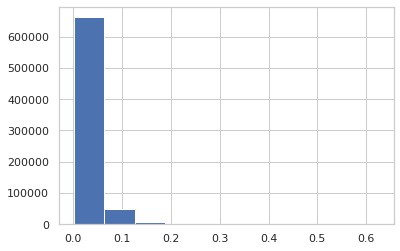

In [39]:
prediccion_202103 = predict_(_2003[seleccionadas].values)
pd.Series(prediccion_202103).hist()

In [40]:
roc_auc = roc_auc_score(_2003[target], prediccion_202103)
print("ROC AUC ::::: ", roc_auc)
print("GINI    ::::: ", roc_auc*2 - 1)

ROC AUC :::::  0.7720062554415492
GINI    :::::  0.5440125108830984


In [41]:
prediccion_202103[prediccion_202103 >= 0.5].shape, prediccion_202103.max()

((13,), 0.6247260570526123)

In [42]:
_2003['score_desembolso'] = prediccion_202103
_2003['GRUPO_PROPENSION'] = list(pd.qcut(_2003['score_desembolso'], cortes_deciles, labels=grupos_score))
_2003.to_csv(uri_validation_202103, index=False)

group_202103 = _2003.groupby(by=['GRUPO_PROPENSION']).agg({
    target: ['mean', 'sum'], 
    'score_desembolso': 'mean'
})
group_202103.round(4)

target_desembolso_f2m_mayor_30_menor_180         score_desembolso
                                                     mean     sum             mean
GRUPO_PROPENSION                                                                  
A                                                  0.0882  6353.0           0.0914
B                                                  0.0435  3136.0           0.0471
C                                                  0.0285  2055.0           0.0335
D                                                  0.0200  1442.0           0.0254
E                                                  0.0147  1056.0           0.0199
F                                                  0.0118   848.0           0.0157
G                                                  0.0088   633.0           0.0125
H                                                  0.0065   465.0           0.0100
I                                                  0.0046   333.0           0.0077
J                                                  0.0026   187.0           0.0048

In [43]:
_2003['GRUPO_PROPENSION_FINO'] = list(pd.qcut(_2003['score_desembolso'], cortes_deciles_fino, labels=grupos_score))
_2003.to_csv(uri_validation_202103, index=False)

group_202103 = _2003.groupby(by=['GRUPO_PROPENSION_FINO']).agg({
    target: ['count','mean', 'sum'], 
    'score_desembolso': 'mean'
})
group_202103.round(4)

target_desembolso_f2m_mayor_30_menor_180                 score_desembolso
                                                         count    mean     sum             mean
GRUPO_PROPENSION_FINO                                                                          
A                                                         7207  0.1923  1386.0           0.1838
B                                                        28828  0.0940  2710.0           0.0992
C                                                        36035  0.0626  2257.0           0.0666
D                                                        72070  0.0435  3136.0           0.0471
E                                                       144139  0.0243  3497.0           0.0294
F                                                       144140  0.0132  1904.0           0.0178
G                                                        72069  0.0088   633.0           0.0125
H                                                        71912  0.0065   465.0           0.0100
I                                                        72228  0.0046   333.0           0.0077
J                                                        72070  0.0026   187.0           0.0048

## >> 202104  --> CAMPAÑA 202106

<AxesSubplot:>

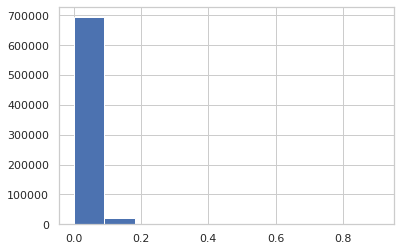

In [44]:
prediccion_202104 = predict_(_2004[seleccionadas].values)
pd.Series(prediccion_202104).hist()

In [45]:
prediccion_202104[prediccion_202104 > 0.5].shape, prediccion_202104.max()

((7,), 0.9039503931999207)

In [46]:
roc_auc_202104 = roc_auc_score(_2004[target], prediccion_202104)
print("ROC AUC ::::: ", roc_auc_202104)
print("GINI    ::::: ", roc_auc_202104*2 - 1)

ROC AUC :::::  0.7526423472331193
GINI    :::::  0.5052846944662386


In [47]:
_2004['score_desembolso'] = prediccion_202104
_2004['GRUPO_PROPENSION'] = list(pd.qcut(_2004['score_desembolso'], cortes_deciles, labels=grupos_score))
_2004.to_csv(uri_validation_202104, index=False)

group_202104 = _2004.groupby(by=['GRUPO_PROPENSION']).agg({
    target: ['mean', 'sum'], 
    'score_desembolso': 'mean'
})
group_202104.round(4)

target_desembolso_f2m_mayor_30_menor_180         score_desembolso
                                                     mean     sum             mean
GRUPO_PROPENSION                                                                  
A                                                  0.0800  5739.0           0.0900
B                                                  0.0446  3198.0           0.0467
C                                                  0.0308  2209.0           0.0332
D                                                  0.0219  1574.0           0.0252
E                                                  0.0176  1262.0           0.0197
F                                                  0.0125   897.0           0.0156
G                                                  0.0098   700.0           0.0126
H                                                  0.0070   498.0           0.0100
I                                                  0.0050   362.0           0.0078
J                                                  0.0034   247.0           0.0048

In [48]:
_2004['GRUPO_PROPENSION_FINO'] = list(pd.qcut(_2004['score_desembolso'], cortes_deciles_fino, labels=grupos_score))
_2004.to_csv(uri_validation_202104, index=False)

group_202104 = _2004.groupby(by=['GRUPO_PROPENSION_FINO']).agg({
    target: ['count','mean', 'sum'], 
    'score_desembolso': 'mean'
})
group_202104.round(4)

target_desembolso_f2m_mayor_30_menor_180                 score_desembolso
                                                         count    mean     sum             mean
GRUPO_PROPENSION_FINO                                                                          
A                                                         7176  0.1417  1017.0           0.1792
B                                                        28702  0.0870  2498.0           0.0979
C                                                        35877  0.0620  2224.0           0.0659
D                                                        71755  0.0446  3198.0           0.0467
E                                                       143510  0.0264  3783.0           0.0292
F                                                       143509  0.0150  2159.0           0.0177
G                                                        71750  0.0098   700.0           0.0126
H                                                        71549  0.0070   498.0           0.0100
I                                                        71961  0.0050   362.0           0.0078
J                                                        71760  0.0034   247.0           0.0048

## >> 202105  --> CAMPAÑA 202107

<AxesSubplot:>

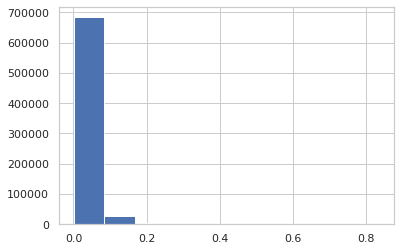

In [49]:
prediccion_202105 = predict_(_2005[seleccionadas].values)
pd.Series(prediccion_202105).hist()

In [50]:
prediccion_202105[prediccion_202105 > 0.5].shape, prediccion_202105.min(), np.median(prediccion_202105), prediccion_202105.mean(), prediccion_202105.max()

((19,),
 0.0011489414609968662,
 0.017951669171452522,
 0.02731734159547669,
 0.8324523568153381)

In [51]:
roc_auc_202105 = roc_auc_score(_2005[target], prediccion_202105)
print("ROC AUC ::::: ", roc_auc_202105)
print("GINI    ::::: ", roc_auc_202105*2 - 1)

ROC AUC :::::  0.76016894021159
GINI    :::::  0.52033788042318


In [52]:
_2005['score_desembolso'] = prediccion_202105
_2005['GRUPO_PROPENSION'] = list(pd.qcut(_2005['score_desembolso'], cortes_deciles, labels=grupos_score))
_2005.to_csv(uri_validation_202105, index=False)

group_202105 = _2005.groupby(by=['GRUPO_PROPENSION']).agg({
    target: ['count','mean', 'sum'], 
    'score_desembolso': 'mean'
})
group_202105.round(4)

target_desembolso_f2m_mayor_30_menor_180                 score_desembolso
                                                    count    mean     sum             mean
GRUPO_PROPENSION                                                                          
A                                                   71567  0.0945  6763.0           0.0926
B                                                   71566  0.0518  3707.0           0.0482
C                                                   71566  0.0372  2660.0           0.0343
D                                                   71566  0.0261  1870.0           0.0259
E                                                   71563  0.0198  1420.0           0.0203
F                                                   71570  0.0140  1003.0           0.0160
G                                                   71566  0.0106   759.0           0.0130
H                                                   71566  0.0073   525.0           0.0102
I                                                   71566  0.0055   396.0           0.0078
J                                                   71567  0.0035   253.0           0.0049

In [53]:
_2005['GRUPO_PROPENSION_FINO'] = list(pd.qcut(_2005['score_desembolso'], cortes_deciles_fino, labels=grupos_score))
_2005.to_csv(uri_validation_202105, index=False)

group_202105 = _2005.groupby(by=['GRUPO_PROPENSION_FINO']).agg({
    target: ['count','mean', 'sum'], 
    'score_desembolso': 'mean'
})
group_202105.round(4)

target_desembolso_f2m_mayor_30_menor_180                 score_desembolso
                                                         count    mean     sum             mean
GRUPO_PROPENSION_FINO                                                                          
A                                                         7157  0.1684  1205.0           0.1836
B                                                        28627  0.1046  2993.0           0.1006
C                                                        35783  0.0717  2565.0           0.0680
D                                                        71566  0.0518  3707.0           0.0482
E                                                       143132  0.0316  4530.0           0.0301
F                                                       143133  0.0169  2423.0           0.0182
G                                                        71566  0.0106   759.0           0.0130
H                                                        71566  0.0073   525.0           0.0102
I                                                        71566  0.0055   396.0           0.0078
J                                                        71567  0.0035   253.0           0.0049

## >> 202106

<AxesSubplot:>

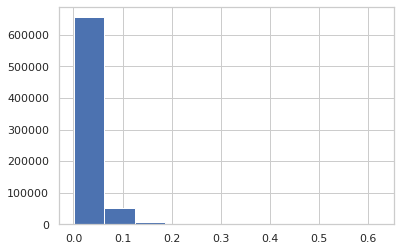

In [54]:
prediccion_202106 = predict_(_2006[seleccionadas].values)
pd.Series(prediccion_202106).hist()

In [55]:
prediccion_202106[prediccion_202106 > 0.5].shape, prediccion_202106.max()

((4,), 0.6200709939002991)

In [56]:
try:
    roc_auc_202106 = roc_auc_score(_2006[target], prediccion_202106)
    print("ROC AUC ::::: ", roc_auc_202106)
    print("GINI    ::::: ", roc_auc_202106*2 - 1)
except Exception as e:
    print("ERROR: ", str(e))

ERROR:  Only one class present in y_true. ROC AUC score is not defined in that case.


In [57]:
_2006['score_desembolso'] = prediccion_202106
_2006['GRUPO_PROPENSION'] = list(pd.qcut(_2006['score_desembolso'], cortes_deciles, labels=grupos_score))
_2006.to_csv(uri_validation_202106, index=False)

group_202106 = _2006.groupby(by=['GRUPO_PROPENSION']).agg({
    target: ['count','mean', 'sum'], 
    'score_desembolso': 'mean'
})
group_202106.round(4)

target_desembolso_f2m_mayor_30_menor_180           score_desembolso
                                                    count mean  sum             mean
GRUPO_PROPENSION                                                                    
A                                                   71804  0.0  0.0           0.0923
B                                                   71803  0.0  0.0           0.0479
C                                                   71802  0.0  0.0           0.0340
D                                                   71804  0.0  0.0           0.0257
E                                                   71803  0.0  0.0           0.0201
F                                                   71746  0.0  0.0           0.0159
G                                                   71861  0.0  0.0           0.0129
H                                                   71802  0.0  0.0           0.0101
I                                                   71804  0.0  0.0           0.0077
J                                                   71804  0.0  0.0           0.0048

In [58]:
_2006['GRUPO_PROPENSION_FINO'] = list(pd.qcut(_2006['score_desembolso'], cortes_deciles_fino, labels=grupos_score))
_2006.to_csv(uri_validation_202106, index=False)

group_202106 = _2006.groupby(by=['GRUPO_PROPENSION_FINO']).agg({
    target: ['count','mean', 'sum'], 
    'score_desembolso': 'mean'
})
group_202106.round(4)

target_desembolso_f2m_mayor_30_menor_180           score_desembolso
                                                         count mean  sum             mean
GRUPO_PROPENSION_FINO                                                                    
A                                                         7181  0.0  0.0           0.1824
B                                                        28721  0.0  0.0           0.1004
C                                                        35902  0.0  0.0           0.0678
D                                                        71803  0.0  0.0           0.0479
E                                                       143606  0.0  0.0           0.0298
F                                                       143549  0.0  0.0           0.0180
G                                                        71861  0.0  0.0           0.0129
H                                                        71802  0.0  0.0           0.0101
I                                                        71804  0.0  0.0           0.0077
J                                                        71804  0.0  0.0           0.0048

## >> 202107

<AxesSubplot:>

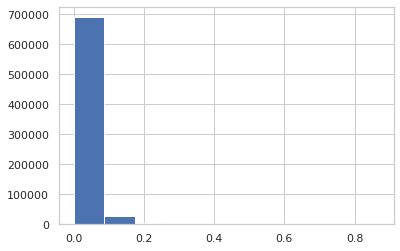

In [59]:
prediccion_202107 = predict_(_2007[seleccionadas].values)
pd.Series(prediccion_202107).hist()

In [60]:
prediccion_202107[prediccion_202107 > 0.5].shape, prediccion_202107.max()

((8,), 0.8674168586730957)

In [61]:
_2007['score_desembolso'] = prediccion_202107
_2007['GRUPO_PROPENSION'] = list(pd.qcut(_2007['score_desembolso'], cortes_deciles, labels=grupos_score))
_2007.to_csv(uri_validation_202107, index=False)

group_202107 = _2007.groupby(by=['GRUPO_PROPENSION']).agg({
    target: ['count','mean', 'sum'], 
    'score_desembolso': 'mean'
})
group_202107.round(4)

target_desembolso_f2m_mayor_30_menor_180           score_desembolso
                                                    count mean  sum             mean
GRUPO_PROPENSION                                                                    
A                                                   72242  0.0  0.0           0.0958
B                                                   72241  0.0  0.0           0.0497
C                                                   72241  0.0  0.0           0.0354
D                                                   72235  0.0  0.0           0.0267
E                                                   72247  0.0  0.0           0.0209
F                                                   72233  0.0  0.0           0.0165
G                                                   72248  0.0  0.0           0.0133
H                                                   72243  0.0  0.0           0.0104
I                                                   72240  0.0  0.0           0.0079
J                                                   72243  0.0  0.0           0.0049

In [62]:
_2007['GRUPO_PROPENSION_FINO'] = list(pd.qcut(_2007['score_desembolso'], cortes_deciles_fino, labels=grupos_score))
_2007.to_csv(uri_validation_202107, index=False)

group_202107 = _2007.groupby(by=['GRUPO_PROPENSION_FINO']).agg({
    target: ['count','mean', 'sum'], 
    'score_desembolso': 'mean'
})
group_202107.round(4)

target_desembolso_f2m_mayor_30_menor_180           score_desembolso
                                                         count mean  sum             mean
GRUPO_PROPENSION_FINO                                                                    
A                                                         7225  0.0  0.0           0.1885
B                                                        28896  0.0  0.0           0.1043
C                                                        36121  0.0  0.0           0.0704
D                                                        72241  0.0  0.0           0.0497
E                                                       144476  0.0  0.0           0.0310
F                                                       144480  0.0  0.0           0.0187
G                                                        72248  0.0  0.0           0.0133
H                                                        72243  0.0  0.0           0.0104
I                                                        72240  0.0  0.0           0.0079
J                                                        72243  0.0  0.0           0.0049

## >> 202108

<AxesSubplot:>

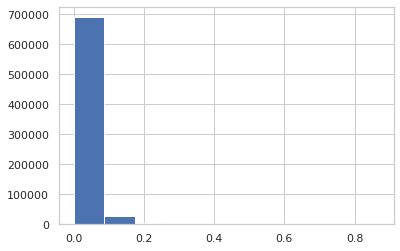

In [63]:
prediccion_202108 = predict_(_2008[seleccionadas].values)
pd.Series(prediccion_202108).hist()

In [64]:
prediccion_202108[prediccion_202108 > 0.5].shape, prediccion_202108.max()

((8,), 0.8674168586730957)

In [65]:
_2008['score_desembolso'] = prediccion_202108
_2008['GRUPO_PROPENSION'] = list(pd.qcut(_2008['score_desembolso'], cortes_deciles, labels=grupos_score))
_2008.to_csv(uri_validation_202108, index=False)

group_202108 = _2008.groupby(by=['GRUPO_PROPENSION']).agg({
    target: ['count','mean', 'sum'], 
    'score_desembolso': 'mean'
})
group_202108.round(4)

target_desembolso_f2m_mayor_30_menor_180           score_desembolso
                                                    count mean  sum             mean
GRUPO_PROPENSION                                                                    
A                                                   72242  0.0  0.0           0.0958
B                                                   72241  0.0  0.0           0.0497
C                                                   72241  0.0  0.0           0.0354
D                                                   72235  0.0  0.0           0.0267
E                                                   72247  0.0  0.0           0.0209
F                                                   72233  0.0  0.0           0.0165
G                                                   72248  0.0  0.0           0.0133
H                                                   72243  0.0  0.0           0.0104
I                                                   72240  0.0  0.0           0.0079
J                                                   72243  0.0  0.0           0.0049

In [66]:
_2008['GRUPO_PROPENSION_FINO'] = list(pd.qcut(_2008['score_desembolso'], cortes_deciles_fino, labels=grupos_score))
_2008.to_csv(uri_validation_202108, index=False)

group_202108 = _2008.groupby(by=['GRUPO_PROPENSION_FINO']).agg({
    target: ['count','mean', 'sum'], 
    'score_desembolso': 'mean'
})
group_202108.round(4)

target_desembolso_f2m_mayor_30_menor_180           score_desembolso
                                                         count mean  sum             mean
GRUPO_PROPENSION_FINO                                                                    
A                                                         7225  0.0  0.0           0.1885
B                                                        28896  0.0  0.0           0.1043
C                                                        36121  0.0  0.0           0.0704
D                                                        72241  0.0  0.0           0.0497
E                                                       144476  0.0  0.0           0.0310
F                                                       144480  0.0  0.0           0.0187
G                                                        72248  0.0  0.0           0.0133
H                                                        72243  0.0  0.0           0.0104
I                                                        72240  0.0  0.0           0.0079
J                                                        72243  0.0  0.0           0.0049

### Eliminación de Deploy (!IMPORTANTE)

In [67]:
print(dir(model))

['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_cache', '_abc_negative_cache', '_abc_negative_cache_version', '_abc_registry', '_compilation_job_name', '_compiled_models', '_current_job_name', '_enable_network_isolation', '_ensure_base_job_name', '_ensure_latest_training_job', '_get_or_create_name', '_prepare_collection_configs', '_prepare_debugger_for_training', '_prepare_debugger_rules', '_prepare_for_training', '_prepare_init_params_from_job_description', '_prepare_profiler_for_training', '_prepare_profiler_rules', '_prepare_rules', '_set_default_rule_config', '_set_source_s3_uri', 'attach', 'base_job_name', 'checkpoint_local_path', 'checkpoint_s3_uri', 'code_cha

In [68]:
print(dir(model_predictor))

['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_cache', '_abc_negative_cache', '_abc_negative_cache_version', '_abc_registry', '_context', '_create_request_args', '_delete_endpoint_config', '_endpoint_config_name', '_get_endpoint_config_name', '_get_model_monitor_class', '_get_model_names', '_handle_response', '_model_names', 'accept', 'content_type', 'delete_endpoint', 'delete_model', 'delete_predictor', 'deserializer', 'disable_data_capture', 'enable_data_capture', 'endpoint', 'endpoint_context', 'endpoint_name', 'list_monitors', 'predict', 'sagemaker_session', 'serializer', 'update_data_capture_config', 'update_endpoint']


In [69]:
try:
    model_predictor.delete_model()
except Esception as e:
    print(str(e))

Deleting model with name: xgboost-vpc-7-2021-09-28-04-08-21-500


In [70]:
try:
    model_predictor.delete_endpoint()
except Esception as e:
    print(str(e))

Deleting endpoint configuration with name: xgboost-vpc-7-2021-09-28-04-08-21-500
Deleting endpoint with name: xgboost-vpc-7-2021-09-28-04-08-21-500


#### En caso de error o olvido , dirigirese al panel izquierdo de la interfaz de Sage Maker , ingresar a la sección de Inferencia e liminar el modelo y punto de enlace de manera manual en la subsecciones correspondientes.  (Hacer esto en caso no se desea dejar una maquina encendida 24 *7 con el modelo activo)

In [71]:
len(list_model_code)

37

## >> FUSION

In [72]:
_2004['periodo_val'] = '202104'
_2005['periodo_val'] = '202105'
_2006['periodo_val'] = '202106'
_2007['periodo_val'] = '202107'
_2008['periodo_val'] = '202108'
_2003['periodo_val'] = '202103'

In [73]:
common_cols = set(_2003.columns) & set(_2004.columns) & set(_2005.columns) & set(_2006.columns) & set(_2007.columns) & set(_2008.columns)
print(common_cols)

{'_categoryc_nroregs_reactiva_bcos', '_categoryc_sow_ibk', 'score_desembolso', '_categoryc_porc_coloc_direct_vig_no_ibk', '_categoryc_sow_cajas', 'sow_ibk', 'saldo_coloc_direct_vig_cmpt', 'porc_coloc_direct_vig_cmpt', '_categoryc_coloc_direct_vig_bcos', '_range_coloc_indirectas', 'deuda_sf_prom_ult9m', '_range_reactiva', 'nro_var_10k_30k_negativa_u3', '_range_coloc_direct_vig_cmpt', '_categoryc_nroregs_fae_bcos', 'nro_entidades', 'ult_var_saldo_ajustado_amt', 'saldo_coloc_direct_vig_no_ibk', 'cod_sbs_val', 'saldo_coloc_direct_vig_cajas', 'prom_gar_u12m', '_range_coloc_direct_vig_cajas', 'monto_adquirido_u6_amt', '_range_coloc_direct_vig_bcos', '_range_coloc_direct_vig_ibk', 'porc_coloc_direct_vig_cajas', 'nroregs_fae_bcos', '_categoryc_coloc_direct_vig_no_ibk', 'nroregs_reactiva_bcos', 'nro_var_10k_30k_negativa_u6', 'saldo_reactiva', 'porc_coloc_direct_vig_no_ibk', '_range_fae', '_categoryc_coloc_direct_vig_competencia', '_categoryc_coloc_direct_vig_cajas', 'periodo_val', 'saldo_coloc_

In [74]:
common_cols = list(common_cols)
len(common_cols)

65

In [75]:
_2003['periodo_val'].value_counts(),_2004['periodo_val'].value_counts(), _2005['periodo_val'].value_counts(), _2006['periodo_val'].value_counts(), _2007['periodo_val'].value_counts(), _2008['periodo_val'].value_counts()

(202103    720698
 Name: periodo_val, dtype: int64,
 202104    717549
 Name: periodo_val, dtype: int64,
 202105    715663
 Name: periodo_val, dtype: int64,
 202106    718033
 Name: periodo_val, dtype: int64,
 202107    722413
 Name: periodo_val, dtype: int64,
 202108    722413
 Name: periodo_val, dtype: int64)

In [76]:
init = ['periodo_val', 'cod_sbs_val', 'score_desembolso', 'GRUPO_PROPENSION', 'GRUPO_PROPENSION_FINO', 'target_desembolso_f2m_mayor_30_menor_180']

In [77]:
categoryc = [col for col in common_cols if 'categoryc' in col.lower() and col not in init]
print(len(categoryc), categoryc)

15 ['_categoryc_nroregs_reactiva_bcos', '_categoryc_sow_ibk', '_categoryc_porc_coloc_direct_vig_no_ibk', '_categoryc_sow_cajas', '_categoryc_coloc_direct_vig_bcos', '_categoryc_nroregs_fae_bcos', '_categoryc_coloc_direct_vig_no_ibk', '_categoryc_coloc_direct_vig_competencia', '_categoryc_coloc_direct_vig_cajas', '_categoryc_coloc_direct_vig_ibk', '_categoryc_porc_coloc_direct_vig_cmpt', '_categoryc_porc_coloc_direct_vig_cajas', '_categoryc_porc_coloc_direct_vig_ibk', '_categoryc_sow_otros_bancos', '_categoryc_porc_coloc_direct_vig_bcos']


In [78]:
range_ = [col for col in common_cols if 'range' in col.lower() and col not in init]
print(len(range_), range_)

9 ['_range_coloc_indirectas', '_range_reactiva', '_range_coloc_direct_vig_cmpt', '_range_coloc_direct_vig_cajas', '_range_coloc_direct_vig_bcos', '_range_coloc_direct_vig_ibk', '_range_fae', '_range_coloc_directas', '_range_coloc_direct_vig_no_ibk']


In [79]:
percent = [col for col in common_cols if ('porc' in col.lower() or 'sow' in col.lower()) and 'categoryc' not in col.lower()]
print(len(percent), percent)

8 ['sow_ibk', 'porc_coloc_direct_vig_cmpt', 'porc_coloc_direct_vig_cajas', 'porc_coloc_direct_vig_no_ibk', 'porc_coloc_direct_vig_bcos', 'sow_otros_bancos', 'porc_coloc_direct_vig_ibk', 'sow_cajas']


In [80]:
saldo = [col for col in common_cols if 'saldo' in col.lower()]
print(len(saldo), saldo)

13 ['saldo_coloc_direct_vig_cmpt', 'ult_var_saldo_ajustado_amt', 'saldo_coloc_direct_vig_no_ibk', 'saldo_coloc_direct_vig_cajas', 'saldo_reactiva', 'saldo_coloc_indirectas', 'var_neta_saldo_ajustado_u3_amt', 'saldo_fae', 'saldo_coloc_directas', 'saldo_coloc_direct_vig_bcos', 'saldo_coloc_direct_vig_ibk', 'saldo_coloc_direct_tc', '_cuartil_saldo_coloc_directas']


In [81]:
seleccionadas_2 = [col for col in seleccionadas if col not in categoryc and col not in percent and col not in saldo and col not in range_]
print(len(seleccionadas_2), seleccionadas_2)

13 ['deuda_sf_prom_ult9m', 'prom_reprog_u12m', 'nro_entid_financ_prom_ult9m_cnt', 'monto_adquirido_u6_amt', 'nro_var_10k_30k_negativa_u6', 'prom_gar_u12m', 'nroregs_reactiva_bcos', 'monto_pagado_u3_amt', 'nro_entidades', 'monto_pagado_ult_rcc_amt', 'tendencia_nro_coloc_direct_bancos_v2', 'prom_fae_u12m', 'nro_var_10k_30k_negativa_u3']


In [82]:
order = init + categoryc + range_ + percent + saldo + seleccionadas_2
len(order), len(order) == len(set(order))

(64, True)

In [83]:
set(common_cols) - set(order)

{'nroregs_fae_bcos'}

In [85]:
print(order)

['periodo_val', 'cod_sbs_val', 'score_desembolso', 'GRUPO_PROPENSION', 'GRUPO_PROPENSION_FINO', 'target_desembolso_f2m_mayor_30_menor_180', '_categoryc_nroregs_reactiva_bcos', '_categoryc_sow_ibk', '_categoryc_porc_coloc_direct_vig_no_ibk', '_categoryc_sow_cajas', '_categoryc_coloc_direct_vig_bcos', '_categoryc_nroregs_fae_bcos', '_categoryc_coloc_direct_vig_no_ibk', '_categoryc_coloc_direct_vig_competencia', '_categoryc_coloc_direct_vig_cajas', '_categoryc_coloc_direct_vig_ibk', '_categoryc_porc_coloc_direct_vig_cmpt', '_categoryc_porc_coloc_direct_vig_cajas', '_categoryc_porc_coloc_direct_vig_ibk', '_categoryc_sow_otros_bancos', '_categoryc_porc_coloc_direct_vig_bcos', '_range_coloc_indirectas', '_range_reactiva', '_range_coloc_direct_vig_cmpt', '_range_coloc_direct_vig_cajas', '_range_coloc_direct_vig_bcos', '_range_coloc_direct_vig_ibk', '_range_fae', '_range_coloc_directas', '_range_coloc_direct_vig_no_ibk', 'sow_ibk', 'porc_coloc_direct_vig_cmpt', 'porc_coloc_direct_vig_cajas', '

In [86]:
all_ = pd.concat(
    [
        _2003[order], 
        _2004[order], 
        _2005[order], 
        _2006[order], 
        _2007[order], 
        _2008[order]
    ], 
    ignore_index=True,  
    axis=0
)
all_['periodo_val'].value_counts()

202108    722413
202107    722413
202103    720698
202106    718033
202104    717549
202105    715663
Name: periodo_val, dtype: int64

In [87]:
all_.to_csv(uri_output.replace('output3', 'campania') + '/seguimiento_aws_to_campania.csv', index=False)

In [ ]:
_2003[order].to_csv(uri_output.replace('output3', 'campania') + '/seguimiento_aws_to_campania_202103.csv', index=False)
_2004[order].to_csv(uri_output.replace('output3', 'campania') + '/seguimiento_aws_to_campania_202104.csv', index=False)
_2005[order].to_csv(uri_output.replace('output3', 'campania') + '/seguimiento_aws_to_campania_202105.csv', index=False)
_2006[order].to_csv(uri_output.replace('output3', 'campania') + '/seguimiento_aws_to_campania_202106.csv', index=False)
_2007[order].to_csv(uri_output.replace('output3', 'campania') + '/seguimiento_aws_to_campania_202107.csv', index=False)
_2008[order].to_csv(uri_output.replace('output3', 'campania') + '/seguimiento_aws_to_campania_202108.csv', index=False)

In [90]:
all_.shape

(4316769, 64)

In [88]:
all_.head()

,periodo_val,cod_sbs_val,score_desembolso,GRUPO_PROPENSION,GRUPO_PROPENSION_FINO,target_desembolso_f2m_mayor_30_menor_180,_categoryc_nroregs_reactiva_bcos,_categoryc_sow_ibk,_categoryc_porc_coloc_direct_vig_no_ibk,_categoryc_sow_cajas,_categoryc_coloc_direct_vig_bcos,_categoryc_nroregs_fae_bcos,_categoryc_coloc_direct_vig_no_ibk,_categoryc_coloc_direct_vig_competencia,_categoryc_coloc_direct_vig_cajas,_categoryc_coloc_direct_vig_ibk,_categoryc_porc_coloc_direct_vig_cmpt,_categoryc_porc_coloc_direct_vig_cajas,_categoryc_porc_coloc_direct_vig_ibk,_categoryc_sow_otros_bancos,_categoryc_porc_coloc_direct_vig_bcos,_range_coloc_indirectas,_range_reactiva,_range_coloc_direct_vig_cmpt,_range_coloc_direct_vig_cajas,_range_coloc_direct_vig_bcos,_range_coloc_direct_vig_ibk,_range_fae,_range_coloc_directas,_range_coloc_direct_vig_no_ibk,sow_ibk,porc_coloc_direct_vig_cmpt,porc_coloc_direct_vig_cajas,porc_coloc_direct_vig_no_ibk,porc_coloc_direct_vig_bcos,sow_otros_bancos,porc_coloc_direct_vig_ibk,sow_cajas,saldo_coloc_direct_vig_cmpt,ult_var_saldo_ajustado_amt,saldo_coloc_direct_vig_no_ibk,saldo_coloc_direct_vig_cajas,saldo_reactiva,saldo_coloc_indirectas,var_neta_saldo_ajustado_u3_amt,saldo_fae,saldo_coloc_directas,saldo_coloc_direct_vig_bcos,saldo_coloc_direct_vig_ibk,saldo_coloc_direct_tc,_cuartil_saldo_coloc_directas,deuda_sf_prom_ult9m,prom_reprog_u12m,nro_entid_financ_prom_ult9m_cnt,monto_adquirido_u6_amt,nro_var_10k_30k_negativa_u6,prom_gar_u12m,nroregs_reactiva_bcos,monto_pagado_u3_amt,nro_entidades,monto_pagado_ult_rcc_amt,tendencia_nro_coloc_direct_bancos_v2,prom_fae_u12m,nro_var_10k_30k_negativa_u3
0,202103,48759904,0.007450,I,I,0.0,0,0. <:0.0],0. <:0.0],4. <0.75:0.9],0. <:0.0],0,0. <:0.0],0. <:0.0],4. <0.75:0.9],0. <:0.0],0. <:0.0],4. <0.75:0.9],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0],0. <:0],0. <:0],1. <0-10k],0. <:0],0. <:0],0. <:0],1. <0-10k],0. <:0],0.0,0.0,1.000,0.000,0.000,0.000,0.0,1.000,0.0,-616.17,0.00,3918.83,0.0,0.0,-1794.37,0.00,3918.83,0.00,0.0,0.0,D,6077.54,4558.153333,1,0.00,0,0.000000,0,1794.37,1,616.17,0.000000,0.000,0
1,202103,149898271,0.030875,C,E,0.0,0,0. <:0.0],0. <:0.0],4. <0.75:0.9],0. <:0.0],0,0. <:0.0],0. <:0.0],4. <0.75:0.9],0. <:0.0],0. <:0.0],4. <0.75:0.9],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0],0. <:0],0. <:0],1. <0-10k],0. <:0],0. <:0],0. <:0],1. <0-10k],0. <:0],0.0,0.0,1.000,0.000,0.000,0.000,0.0,1.000,0.0,900.00,0.00,4000.00,0.0,0.0,-23266.88,0.00,4000.00,0.00,0.0,0.0,D,24525.75,17737.965000,1,900.00,1,2.250000,0,24166.88,1,0.00,0.333333,0.000,1
2,202103,126112726,0.007600,I,I,0.0,0,0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],1,0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0],0. <:0],0. <:0],0. <:0],0. <:0],0. <:0],1. <0-10k],0. <:0],0. <:0],0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.00,0.00,0.00,0.0,0.0,0.00,7000.35,0.00,0.00,0.0,0.0,D,7000.35,0.000000,1,0.00,0,1.000000,0,0.00,1,0.00,1.000000,5833.625,0
3,202103,41350989,0.040503,B,D,0.0,0,0. <:0.0],4. <0.75:0.9],1. <0.0:0.25],4. <0.75:0.9],0,4. <0.75:0.9],0. <:0.0],1. <0.0:0.25],0. <:0.0],0. <:0.0],1. <0.0:0.25],0. <:0.0],4. <0.75:0.9],4. <0.75:0.9],0. <:0],0. <:0],0. <:0],2. <10k:30k],<3. 30k:120k],0. <:0],0. <:0],<3. 30k:120k],<3. 30k:120k],0.0,0.0,0.238,0.762,0.762,0.762,0.0,0.238,0.0,-2926.29,43949.88,13741.89,0.0,0.0,-9636.02,0.00,57691.77,43949.88,0.0,0.0,B,44310.89,5256.226667,2,57852.76,0,13672.668333,0,9636.02,2,2926.29,1.000000,0.000,0
4,202103,45334317,0.016579,F,F,0.0,0,0. <:0.0],4. <0.75:0.9],0. <:0.0],4. <0.75:0.9],0,4. <0.75:0.9],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],0. <:0.0],4. <0.75:0.9],4. <0.75:0.9],0. <:0],0. <:0],0. <:0],0. <:0],2. <10k:30k],0. <:0],0. <:0],2. <10k:30k],2. <10k:30k],0.0,0.0,0.000,1.000,1.000,1.000,0.0,0.000,0.0,-1147.40,16089.55,0.00,0.0,0.0,-3255.22,0.00,16089.55,16089.55,0.0,0.0,C,11194.51,0.000000,0,9737.84,0,0.916667,0,3255.22,1,1147.40,1.000000,0.000,0


In [89]:
assert False

AssertionError: 

## ANALISIS TODAS LAS VERSIONES

In [ ]:
%%time

for model_code in list_model_code:
    print("/"*25, model_code)
    
    model_ok = 0
    try:
        model = Estimator.attach(model_code)
        model_predictor = model.deploy(
            initial_instance_count=1, 
            instance_type='ml.m5.xlarge',
            serializer=CSVSerializer()
        )    
        print(model_predictor.content_type, model_predictor.endpoint_name)
        model_ok = 1
    except Exception as e:
        print("ERROR 1",str(e))
    
    if model_ok == 0:
        rcc_202104.append(-1)
        rcc_202105.append(-1)
        rcc_202106.append(-1)
        continue
        
    ### RCC
    prediccion_202102 = predict_(_2002[seleccionadas].values)
    roc_auc_202102 = roc_auc_score(_2002[target], prediccion_202102)
    rcc_202104.append(roc_auc_202102)
    print("prediccion_202104: ", roc_auc_202102, "descriptivos: ", prediccion_202102.min(), prediccion_202102.mean(),  np.median(prediccion_202102),  prediccion_202102.max())

    prediccion_202103 = predict_(_2003[seleccionadas].values)
    roc_auc_202103 = roc_auc_score(_2003[target], prediccion_202103)
    rcc_202105.append(roc_auc_202103)
    print("prediccion_202105: ", roc_auc_202103, "descriptivos: ", prediccion_202103.min(), prediccion_202103.mean(),  np.median(prediccion_202103),  prediccion_202103.max())

    prediccion_202104 = predict_(_2004[seleccionadas].values)
    roc_auc_202104 = roc_auc_score(_2004[target], prediccion_202104)
    rcc_202106.append(roc_auc_202104)
    print("prediccion_202106: ", roc_auc_202104, "descriptivos: ", prediccion_202104.min(), prediccion_202104.mean(),  np.median(prediccion_202104),  prediccion_202104.max())
        
    try:
        model_predictor.delete_model()
        print("del model")
    except Esception as e:
        print("ERROR 2",str(e))
        
    try:
        model_predictor.delete_endpoint()
        print("del endpoint")
    except Exception as e:
        print("ERROR 3",str(e))
        
    try:
        del model
        del model_predictor
    except Exception as e:
        print("ERROR 4",str(e))

In [ ]:
resultados['valid_rcc_202104'] = rcc_202104
resultados['valid_rcc_202105'] = rcc_202105
resultados['valid_rcc_202106'] = rcc_202106

In [ ]:
print(save_results)

In [ ]:
resultados.head()

## SAVE

In [ ]:
resultados.to_csv(save_results, index=False)